In [2]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pymc import Model, Normal, sample, HalfNormal
import arviz as az

import yfinance as yf
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [79]:
start = '2014-12-31'
end = '2022-12-31'
ext_factors = pd.read_parquet('factors.parquet')
stock_prices = pd.read_parquet('stock_prices.parquet')
stock_prices = stock_prices.loc[start:end, :]
market_prices = yf.download("^SET.BK", start=start, end=end)['Adj Close']

stock_rets = stock_prices.pct_change()
stock_return_daily = stock_rets.copy()
ext_factors = ext_factors.resample('M').agg(lambda x: (x + 1).prod() - 1)
stock_rets = stock_rets.resample('M').agg(lambda x: (x + 1).prod() - 1)

ext_factors[[f'{factor}_lag' for factor in ext_factors.columns]] = ext_factors.shift(1)
stock_rets[[f'{symbol}_lag' for symbol in stock_rets.columns]] = stock_rets.shift(1)

ext_factors = ext_factors.dropna()
stock_rets = stock_rets.dropna()





C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
C:\Users\TGAdmin\AppData\Local\Temp\ipykernel_15472\3134598543.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_rets = stock_prices.pct_change()
C:\Users\TGAdmin\AppData\Local\Temp\ipykernel_15472\3134598543.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ext_factors = ext_factors.resample('M').agg(lambda x: (x + 1).prod() - 1)
C:\Users\TGAdmin\AppData\Local\Temp\ipykerne

In [4]:
# train/test split
start_train_at = '2014-12-31'
end_train_at = '2021-12-31'
start_test_at = '2022-01-31'
X_train = pd.concat([stock_rets.loc[start_train_at:end_train_at, :], ext_factors.loc[start_train_at:end_train_at, :]], axis=1)
X_test = pd.concat([stock_rets.loc[start_test_at:, :], ext_factors.loc[start_test_at:, :]], axis=1)

In [5]:
X_train

,AAV.BK,ADVANC.BK,AEONTS.BK,AH.BK,AMATA.BK,AOT.BK,AP.BK,ASIAN.BK,BAFS.BK,BANPU.BK,...,WHA.BK_lag,SET_index_lag,mkt,E,S,G,mkt_lag,E_lag,S_lag,G_lag
2015-02-28,-0.018349,-0.048979,-0.013636,0.083916,0.120482,-0.046297,0.085937,0.435714,0.039062,0.244856,...,0.193548,0.066071,0.007893,0.446534,-0.090822,0.041178,0.055107,-0.222474,-0.315859,-0.231132
2015-03-31,-0.065421,0.042742,-0.041474,-0.070876,-0.129032,-0.093851,0.035971,-0.184080,-0.045113,-0.024794,...,0.075818,0.003643,-0.048033,1.147584,0.931208,0.646361,0.007893,0.446534,-0.090822,0.041178
2015-04-30,-0.040000,0.012658,-0.010996,0.027972,0.136329,0.035714,0.020833,-0.012195,0.121158,0.006338,...,-0.125000,-0.051084,0.021332,0.385266,0.293041,0.445276,-0.048033,1.147584,0.931208,0.646361
2015-05-31,-0.020833,-0.025000,-0.061881,-0.047619,-0.067039,0.032960,-0.011939,0.006172,-0.017857,-0.086207,...,0.333333,0.013812,-0.020494,-0.336553,-0.094921,-0.263620,0.021332,0.385266,0.293041,0.445276
2015-06-30,-0.063830,0.025641,-0.005277,0.000000,-0.101797,0.016779,0.028571,0.042945,-0.063636,-0.037736,...,-0.090476,-0.020102,0.003738,0.262981,0.485950,0.486148,-0.020494,-0.336553,-0.094921,-0.263620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,0.168067,0.067312,0.164706,0.089018,0.038612,0.128319,0.063291,-0.089942,0.098790,-0.018425,...,-0.043750,-0.041485,0.082452,2.780348,4.505651,-0.685415,-0.040938,-0.931164,-0.948185,-0.240747
2021-09-30,-0.028777,0.042553,-0.080808,-0.071429,-0.037234,-0.043137,-0.029762,-0.005747,0.064220,0.145455,...,0.065359,0.076765,-0.016590,1.183720,2.100983,-0.731005,0.082452,2.780348,4.505651,-0.685415
2021-10-31,0.081482,-0.035714,0.040956,0.019231,0.127072,0.057377,0.085890,-0.086705,-0.017241,-0.080645,...,-0.042945,-0.020180,0.010872,-0.670605,0.458597,-0.689751,-0.016590,1.183720,2.100983,-0.731005
2021-11-30,-0.164384,0.089947,-0.029412,0.122642,-0.049020,-0.073643,-0.016949,0.031646,-0.122807,-0.096491,...,0.083334,0.011055,-0.034053,-0.902335,-0.978697,0.717836,0.010872,-0.670605,0.458597,-0.689751


In [6]:
X_test


,AAV.BK,ADVANC.BK,AEONTS.BK,AH.BK,AMATA.BK,AOT.BK,AP.BK,ASIAN.BK,BAFS.BK,BANPU.BK,...,WHA.BK_lag,SET_index_lag,mkt,E,S,G,mkt_lag,E_lag,S_lag,G_lag
2022-01-31,-0.015748,-0.043478,-0.029178,-0.037037,1.904772e-02,4.508193e-02,0.068063,-0.078212,6.862745e-02,0.047170,...,0.073171,0.056691,-0.004626,2.728603,3.487196,1.490064,0.056876,-0.890117,-0.522251,-0.613177
2022-02-28,0.008000,0.059629,0.076503,-0.119231,-4.440892e-16,7.843163e-03,0.039216,-0.060606,-5.504587e-02,-0.018018,...,-0.028409,-0.005315,0.025024,-0.625301,-0.924748,-0.453828,-0.004626,2.728603,3.487196,1.490064
2022-03-31,0.023810,0.017467,-0.007614,0.104693,3.271033e-02,3.112839e-02,0.037736,0.000000,2.220446e-16,0.009174,...,-0.005848,0.022058,0.012803,-0.757457,-0.507373,-0.758812,0.025024,-0.625301,-0.924748,-0.453828
2022-04-30,0.100775,-0.077253,-0.015345,-0.056452,-1.235725e-04,7.547195e-03,0.072727,0.097089,1.262136e-01,0.143480,...,-0.005882,0.005970,-0.011661,0.471555,-0.627084,0.801230,0.012803,-0.757457,-0.507373,-0.758812
2022-05-31,-0.007042,0.009302,0.006667,0.025641,-7.798159e-02,4.494385e-02,-0.005215,-0.012048,-1.724138e-02,0.008130,...,-0.005917,-0.016399,0.001255,-0.056896,-0.411707,0.781736,-0.011661,0.471555,-0.627084,0.801230
2022-06-30,0.021277,-0.103687,-0.096859,-0.087500,-8.955231e-02,1.792104e-02,-0.107143,0.054878,8.771930e-03,0.016129,...,-0.025651,-0.002417,-0.057464,0.134897,1.574954,0.405824,0.001255,-0.056896,-0.411707,0.781736
2022-07-31,-0.069444,0.033419,-0.037681,-0.036530,-1.639337e-02,-1.056336e-02,-0.025000,-0.075144,-4.347826e-02,0.063492,...,-0.043750,-0.057160,0.006373,1.466634,1.668548,-0.675061,-0.057464,0.134897,1.574954,0.405824
2022-08-31,0.059701,-0.028009,-0.003012,0.226318,1.727806e-01,3.558720e-02,0.025641,0.129204,3.636364e-02,0.082090,...,-0.019608,0.005152,0.046397,0.524031,-0.439201,-0.596649,0.006373,1.466634,1.668548,-0.675061
2022-09-30,0.014085,0.015625,-0.006042,0.158416,-1.100479e-01,-3.436385e-03,-0.050000,0.033708,1.228070e-01,-0.124163,...,0.166667,0.039660,-0.025462,2.264945,-0.532802,0.491849,0.046397,0.524031,-0.439201,-0.596649
2022-10-31,0.111111,-0.020513,0.010018,0.034188,4.838709e-02,2.068962e-02,0.031579,-0.054348,-3.125000e-02,0.016260,...,0.005714,-0.030154,0.013131,0.784105,-0.470394,-0.798323,-0.025462,2.264945,-0.532802,0.491849


In [7]:
model_dict = {}
symbols = ['MINT.BK', 'BANPU.BK', 'TOP.BK', 
           'DELTA.BK', 'IRPC.BK', 'PTTGC.BK', 
           'WHA.BK', 'SCC.BK','CPN.BK', 
           'CENTEL.BK', 'PTT.BK', 'BCP.BK']
# symbols = ['SET_index']
for symbol in symbols:
    with Model() as model:
        beta0 = Normal('beta0', 0, 10)
        beta1 = Normal('beta1', 0, 10)
        # beta2 = Normal('beta2', 0, 10)
        # beta3 = Normal('beta3', 0, 10)
        # beta4 = Normal('beta4', 0, 10)
        stdev = HalfNormal('stdev', 10)
        X_l1 = pm.MutableData( 'lagged_X', X_train.loc[:, f'{symbol}_lag'].values)
        R_l1 = pm.MutableData('lagged_R_l1', X_train.loc[:, 'mkt_lag'].values)
        # R_l2 = pm.MutableData('lagged_R_l2',X_train.loc[:, 'E_lag'].values)
        # R_l3 = pm.MutableData('lagged_R_l3',X_train.loc[:, 'S_lag'].values)
        # R_l4 = pm.MutableData('lagged_R_l4',X_train.loc[:, 'G_lag'].values)
        X = X_train.loc[:, symbol].values
        mu = X_l1 * beta0 + R_l1 * beta1 # + R_l2 * beta2 + R_l3 * beta3 + R_l4 * beta4
        obs = Normal('obs', mu=mu, sigma=stdev, observed=X)
        ar_trace = sample(20000, chains=1)
        model_dict[symbol] = ar_trace


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta0, beta1, stdev]


Sampling 1 chain for 1_000 tune and 20_000 draw iterations (1_000 + 20_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [8]:
import numpy as np
def predict(X, model):
    draw = model.posterior['draw'].shape[0]
    
    beta0_sample = model.posterior['beta0']
    beta1_sample = model.posterior['beta1']
    # beta2_sample = model.posterior['beta2']
    # beta3_sample = model.posterior['beta3']
    # beta4_sample = model.posterior['beta4']
    next_period_return = (X.filter(like='.BK').iloc[-1, 0] * beta0_sample +
                          X['mkt_lag'].iloc[-1] * beta1_sample)
                          # X['E_lag'].iloc[-1] * beta2_sample + 
                          # X['S_lag'].iloc[-1] * beta3_sample + 
                          # X['G_lag'].iloc[-1] * beta4_sample)

    next_period_return = np.array(next_period_return).reshape(draw, )
    return next_period_return 

In [9]:
universe = ['MINT.BK', 'BANPU.BK', 'TOP.BK',
                      'DELTA.BK', 'IRPC.BK', 'PTTGC.BK', 
                      'WHA.BK', 'SCC.BK','CPN.BK', 
                      'CENTEL.BK', 'PTT.BK', 'BCP.BK']


In [10]:
portfolio = stock_prices.loc['2022-01-01':'2022-01-31', universe]
portfolio

,MINT.BK,BANPU.BK,TOP.BK,DELTA.BK,IRPC.BK,PTTGC.BK,WHA.BK,SCC.BK,CPN.BK,CENTEL.BK,PTT.BK,BCP.BK
Date,,,,,,,,,,,,
2022-01-04,29.289856,9.065233,42.142235,39.403347,3.622193,55.288166,3.297594,365.525848,52.935890,31.75,33.109207,22.043390
2022-01-05,29.289856,9.321797,43.827919,39.600365,3.696495,56.217377,3.279068,366.470367,51.990608,32.00,33.980503,22.691727
2022-01-06,28.059189,9.407319,43.406498,38.812302,3.640769,54.823559,3.223491,360.803314,50.572678,30.50,33.109207,22.043390
2022-01-07,28.305323,9.578361,44.038631,39.009312,3.659344,54.823559,3.186440,358.914276,49.863716,30.50,33.762680,23.340065
2022-01-10,28.551456,9.578361,43.827919,38.910805,3.677919,55.520466,3.186440,360.803314,50.336357,30.75,33.544861,23.340065
2022-01-11,28.305323,9.578361,43.827919,40.388435,3.770796,55.985073,3.149388,367.414886,51.045319,31.25,33.980503,23.340065
2022-01-12,28.551456,9.578361,44.460056,41.176498,3.826522,56.681984,3.149388,368.359406,51.045319,33.50,34.198334,23.772285
2022-01-13,28.551456,9.578361,44.038631,40.782471,3.789371,56.681984,3.149388,368.359406,50.809002,33.50,34.198334,23.123951
2022-01-14,29.043722,9.578361,44.038631,40.191414,3.770796,56.217377,3.130862,367.414886,50.809002,34.00,33.762680,23.123951


In [11]:
market_prices = stock_prices.loc['2015-01-01':'2022-01-31', 'SET_index']
market_prices.head()


Date
2015-01-05    1483.25
2015-01-06    1477.58
2015-01-07    1500.75
2015-01-08    1521.62
2015-01-09    1529.42
Name: SET_index, dtype: float64

In [12]:
mcaps = {}
for t in universe:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MINT.BK': 185691848704,
 'BANPU.BK': 55604895744,
 'TOP.BK': 131238109184,
 'DELTA.BK': 910587396096,
 'IRPC.BK': 38780137472,
 'PTTGC.BK': 175845163008,
 'WHA.BK': 71744643072,
 'SCC.BK': 301200015360,
 'CPN.BK': 281621987328,
 'CENTEL.BK': 59737501696,
 'PTT.BK': 964001202176,
 'BCP.BK': 60584484864}

In [13]:
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()

delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()


0.31833469667581227

In [14]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior


MINT.BK      0.024862
BANPU.BK     0.024728
TOP.BK       0.026986
DELTA.BK     0.034505
IRPC.BK      0.028277
PTTGC.BK     0.025584
WHA.BK       0.022086
SCC.BK       0.022961
CPN.BK       0.023680
CENTEL.BK    0.028833
PTT.BK       0.030263
BCP.BK       0.028686
dtype: float64

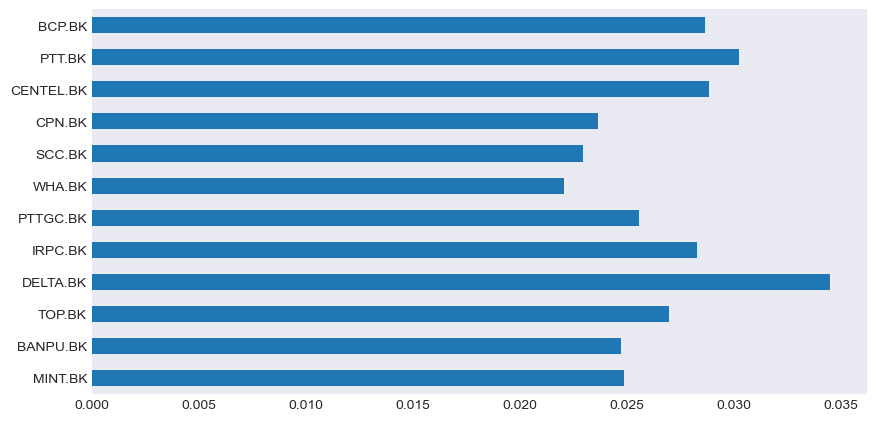

In [15]:
market_prior.plot.barh(figsize=(10,5));


In [16]:
views = {}
view_uncertainty = {}
for symbol in universe:
    X = pd.concat([ext_factors.filter(like='lag'),stock_rets[f'{symbol}_lag']], axis=1)
    pred = predict(X, model_dict[symbol])
    views[symbol] = pred.mean()
    view_uncertainty[symbol] = pred.var()

In [17]:
views

{'MINT.BK': -0.023409477119566268,
 'BANPU.BK': 0.010658344869713005,
 'TOP.BK': 0.0011732412363928998,
 'DELTA.BK': 0.027716136863754265,
 'IRPC.BK': -0.0039911207175563485,
 'PTTGC.BK': 0.011220114232381586,
 'WHA.BK': 0.009225067833431962,
 'SCC.BK': 0.003384474341856556,
 'CPN.BK': -0.009961986484428446,
 'CENTEL.BK': -0.004133064874891291,
 'PTT.BK': 0.0016554813965940652,
 'BCP.BK': -0.0032788779185220244}

In [18]:
view_uncertainty

{'MINT.BK': 0.00011136042593653905,
 'BANPU.BK': 2.7605017833552314e-05,
 'TOP.BK': 4.069864319274181e-05,
 'DELTA.BK': 0.0003236431855052913,
 'IRPC.BK': 5.302029674256017e-05,
 'PTTGC.BK': 0.00026099937522509203,
 'WHA.BK': 3.7251860726178766e-05,
 'SCC.BK': 1.6874766480133565e-05,
 'CPN.BK': 5.039427463747399e-05,
 'CENTEL.BK': 5.736280389042651e-05,
 'PTT.BK': 0.0003267841718851164,
 'BCP.BK': 3.068099498716976e-05}

In [19]:
omega = np.diag(list(view_uncertainty.values()))
omega

array([[1.11360426e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.76050178e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.06986432e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.23643186e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.30202967e-05, 0.00000000e+00, 0.00000000e+00, 0.00

In [20]:
bl = BlackLittermanModel(S, pi="equal", risk_aversion=delta,
                         absolute_views=views, omega=omega)

In [21]:
ret_bl = bl.bl_returns()
ret_bl

MINT.BK     -0.020395
BANPU.BK     0.011185
TOP.BK       0.001275
DELTA.BK     0.024240
IRPC.BK     -0.003080
PTTGC.BK     0.012577
WHA.BK       0.010301
SCC.BK       0.004014
CPN.BK      -0.008801
CENTEL.BK   -0.004522
PTT.BK       0.000650
BCP.BK      -0.003029
dtype: float64

In [22]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(views)],
                       index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
MINT.BK,0.024862,-0.020395,-0.023409
BANPU.BK,0.024728,0.011185,0.010658
TOP.BK,0.026986,0.001275,0.001173
DELTA.BK,0.034505,0.024240,0.027716
IRPC.BK,0.028277,-0.003080,-0.003991
PTTGC.BK,0.025584,0.012577,0.011220
WHA.BK,0.022086,0.010301,0.009225
SCC.BK,0.022961,0.004014,0.003384
CPN.BK,0.023680,-0.008801,-0.009962
CENTEL.BK,0.028833,-0.004522,-0.004133


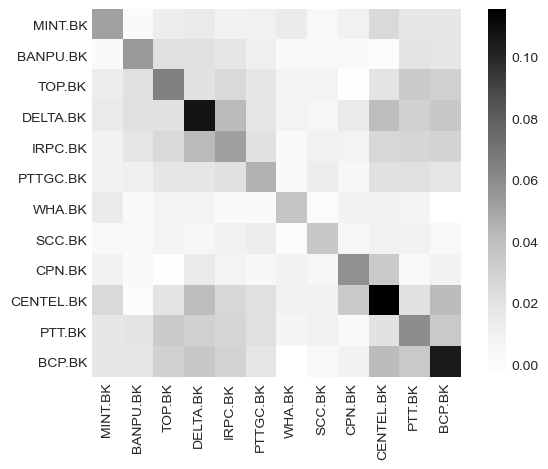

In [23]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [24]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe(risk_free_rate=0.0227/12)
weights = ef.clean_weights()
weights

C:\Users\TGAdmin\anaconda3\envs\pymc_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('MINT.BK', 0.0),
             ('BANPU.BK', 0.17391),
             ('TOP.BK', 0.0),
             ('DELTA.BK', 0.41572),
             ('IRPC.BK', 0.0),
             ('PTTGC.BK', 0.20514),
             ('WHA.BK', 0.1669),
             ('SCC.BK', 0.03833),
             ('CPN.BK', 0.0),
             ('CENTEL.BK', 0.0),
             ('PTT.BK', 0.0),
             ('BCP.BK', 0.0)])

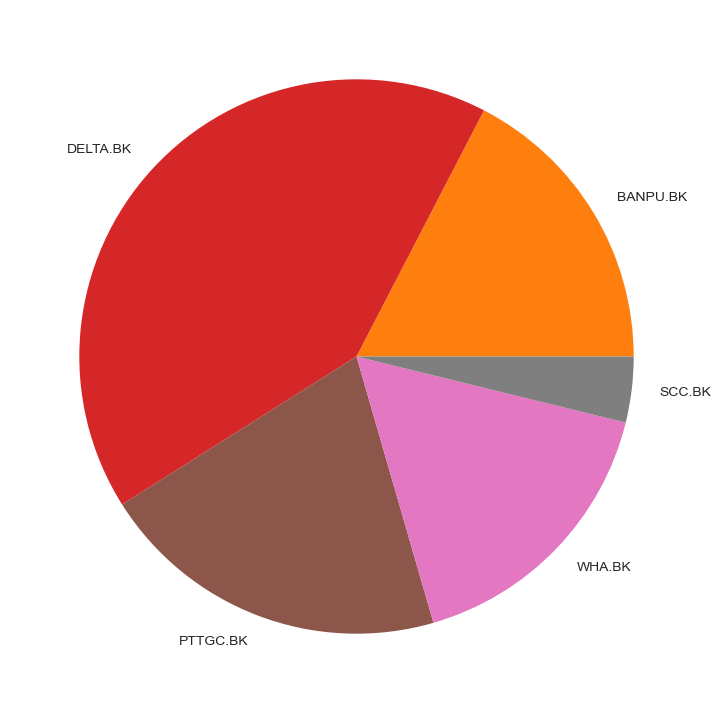

In [25]:
pd.Series(weights).plot.pie(figsize=(9,9));

In [49]:
import riskfolio as rp
rp.plot_pie(w=weights_df.T, title='Sharpe Black Litterman', others=0.05, nrow=25,
                         cmap="tab20", height=6, width=10, ax=None)

ValueError: w must be a column DataFrame

In [52]:
weights_df = pd.DataFrame(list(weights.items()), columns=['Stock', 'Weight'])
weights_df_plot = weights_df

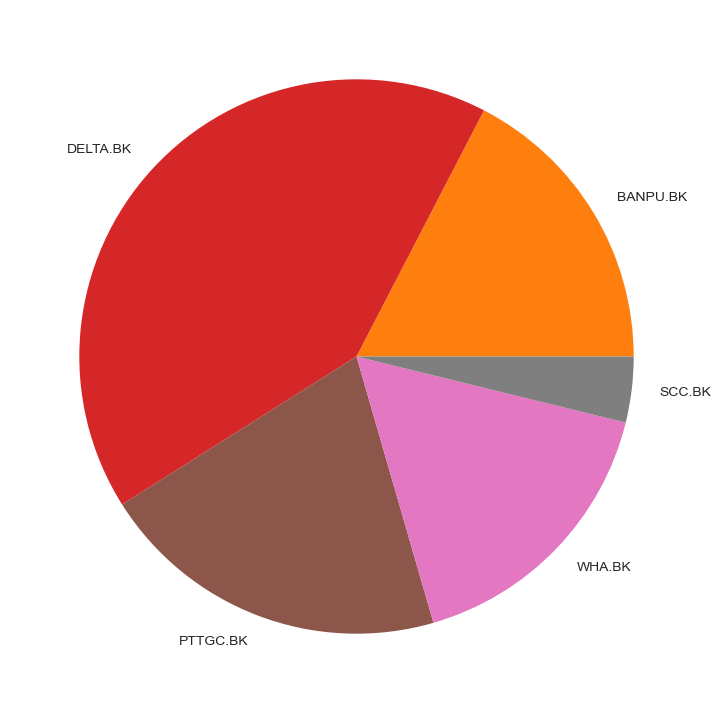

In [31]:
fig = pd.Series(weights).plot.pie(figsize=(9,9));


In [69]:
weights_df_plot = weights_df
weights_df_plot.index = weights_df_plot['Stock']
weights_df_plot = weights_df_plot.drop(columns = ['Stock'])
# weights_df_plot = weights_df_plot.reset_index(drop=True)

weights_df_plot

,Weight
Stock,
MINT.BK,0.00000
BANPU.BK,0.17391
TOP.BK,0.00000
DELTA.BK,0.41572
IRPC.BK,0.00000
PTTGC.BK,0.20514
WHA.BK,0.16690
SCC.BK,0.03833
CPN.BK,0.00000


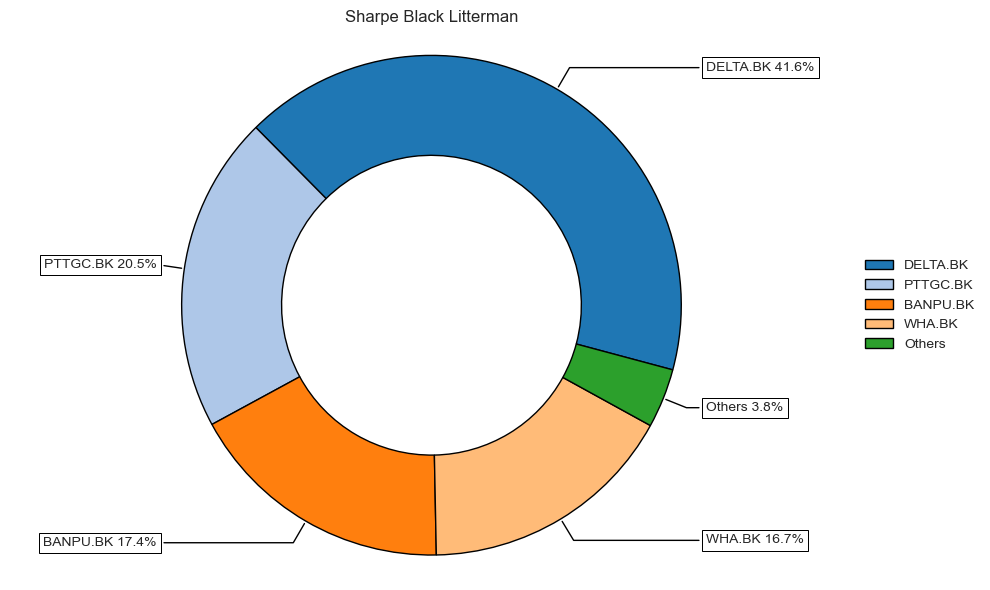

In [70]:
ax = rp.plot_pie(w=weights_df_plot, title='Sharpe Black Litterman', others=0.05, nrow=25,
                         cmap="tab20", height=6, width=10, ax=None)

In [50]:
weights

OrderedDict([('MINT.BK', 0.0),
             ('BANPU.BK', 0.17391),
             ('TOP.BK', 0.0),
             ('DELTA.BK', 0.41572),
             ('IRPC.BK', 0.0),
             ('PTTGC.BK', 0.20514),
             ('WHA.BK', 0.1669),
             ('SCC.BK', 0.03833),
             ('CPN.BK', 0.0),
             ('CENTEL.BK', 0.0),
             ('PTT.BK', 0.0),
             ('BCP.BK', 0.0)])

In [40]:
weights_df = pd.DataFrame(list(weights.items()), columns=['Stock', 'Weight'])
weights_df

OrderedDict([('MINT.BK', 0.0),
             ('BANPU.BK', 0.17391),
             ('TOP.BK', 0.0),
             ('DELTA.BK', 0.41572),
             ('IRPC.BK', 0.0),
             ('PTTGC.BK', 0.20514),
             ('WHA.BK', 0.1669),
             ('SCC.BK', 0.03833),
             ('CPN.BK', 0.0),
             ('CENTEL.BK', 0.0),
             ('PTT.BK', 0.0),
             ('BCP.BK', 0.0)])

ValueError: incomplete format

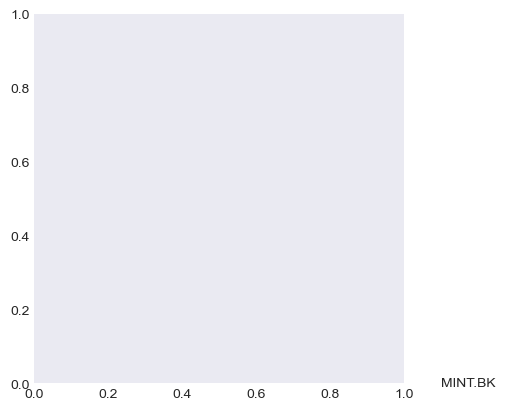

In [41]:
fig, ax = plt.subplots()
ax.pie(weights_df['Weight'],labels=weights_df['Stock'], autopct='%1')

In [28]:
ef.portfolio_performance(risk_free_rate=0.0227/12, verbose=True)

Expected annual return: 1.6%
Annual volatility: 17.8%
Sharpe Ratio: 0.08


(0.01647560147278387, 0.17751097673593827, 0.08215793228275663)

In [27]:
weights

OrderedDict([('MINT.BK', 0.0),
             ('BANPU.BK', 0.17391),
             ('TOP.BK', 0.0),
             ('DELTA.BK', 0.41572),
             ('IRPC.BK', 0.0),
             ('PTTGC.BK', 0.20514),
             ('WHA.BK', 0.1669),
             ('SCC.BK', 0.03833),
             ('CPN.BK', 0.0),
             ('CENTEL.BK', 0.0),
             ('PTT.BK', 0.0),
             ('BCP.BK', 0.0)])

In [42]:
perf = ef.portfolio_performance(risk_free_rate=0.0227/12, verbose=True)
print(f'''Expected annual return: {round(perf[0],2)}%
Annual volatility: {round(perf[1],2)}%
Sharpe Ratio: {round(perf[2],2)}
''')

Expected annual return: 1.6%
Annual volatility: 17.8%
Sharpe Ratio: 0.08
Expected annual return: 0.02%
Annual volatility: 0.18%
Sharpe Ratio: 0.08


In [51]:
weights_df = pd.DataFrame(weights)
weights_df

ValueError: If using all scalar values, you must pass an index

In [71]:
weights_df

,Stock,Weight
Stock,,
MINT.BK,MINT.BK,0.00000
BANPU.BK,BANPU.BK,0.17391
TOP.BK,TOP.BK,0.00000
DELTA.BK,DELTA.BK,0.41572
IRPC.BK,IRPC.BK,0.00000
PTTGC.BK,PTTGC.BK,0.20514
WHA.BK,WHA.BK,0.16690
SCC.BK,SCC.BK,0.03833
CPN.BK,CPN.BK,0.00000


In [95]:
return_df = pd.DataFrame()
for i in range(len(weights_df)):
    perf_return = stock_return_daily[weights_df['Stock'].iloc[i]]*weights_df['Weight'].iloc[i]
    return_df[weights_df['Stock'].iloc[i]] = perf_return
    # perf_return = perf_return.sum()
    # print(perf_return)
    print(weights_df['Stock'].iloc[i],perf_return)


MINT.BK Date
2015-01-05    NaN
2015-01-06   -0.0
2015-01-07    0.0
2015-01-08    0.0
2015-01-09    0.0
             ... 
2022-12-26    0.0
2022-12-27    0.0
2022-12-28    0.0
2022-12-29    0.0
2022-12-30   -0.0
Name: MINT.BK, Length: 1944, dtype: float64
BANPU.BK Date
2015-01-05         NaN
2015-01-06    0.001414
2015-01-07    0.001402
2015-01-08    0.000000
2015-01-09    0.003478
                ...   
2022-12-26    0.001298
2022-12-27   -0.001288
2022-12-28    0.003894
2022-12-29    0.000000
2022-12-30    0.000000
Name: BANPU.BK, Length: 1944, dtype: float64
TOP.BK Date
2015-01-05    NaN
2015-01-06    0.0
2015-01-07    0.0
2015-01-08    0.0
2015-01-09    0.0
             ... 
2022-12-26    0.0
2022-12-27    0.0
2022-12-28   -0.0
2022-12-29    0.0
2022-12-30   -0.0
Name: TOP.BK, Length: 1944, dtype: float64
DELTA.BK Date
2015-01-05         NaN
2015-01-06   -0.012050
2015-01-07    0.043434
2015-01-08    0.000000
2015-01-09   -0.014045
                ...   
2022-12-26    0.007046
2022-

In [97]:
return_df['SUM'] = return_df.sum(axis = 1)
return_df

,MINT.BK,BANPU.BK,TOP.BK,DELTA.BK,IRPC.BK,PTTGC.BK,WHA.BK,SCC.BK,CPN.BK,CENTEL.BK,PTT.BK,BCP.BK,SUM
Date,,,,,,,,,,,,,
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2015-01-06,-0.0,0.001414,0.0,-0.012050,-0.0,0.005975,-0.005384,-0.000681,0.0,0.0,0.0,-0.0,-0.010726
2015-01-07,0.0,0.001402,0.0,0.043434,0.0,0.001935,0.004172,0.000000,0.0,0.0,0.0,0.0,0.050944
2015-01-08,0.0,0.000000,0.0,0.000000,0.0,0.009586,0.001357,0.000520,0.0,0.0,0.0,0.0,0.011463
2015-01-09,0.0,0.003478,0.0,-0.014045,-0.0,-0.003663,-0.002692,0.000513,0.0,0.0,-0.0,0.0,-0.016408
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.0,0.001298,0.0,0.007046,0.0,0.003438,0.000000,0.000115,0.0,0.0,0.0,0.0,0.011897
2022-12-27,0.0,-0.001288,0.0,-0.002310,0.0,0.007890,0.002581,0.000572,0.0,0.0,0.0,0.0,0.007445
2022-12-28,0.0,0.003894,-0.0,-0.006967,0.0,0.001085,0.006778,0.000113,0.0,0.0,0.0,0.0,0.004902


In [143]:
import seaborn as sns

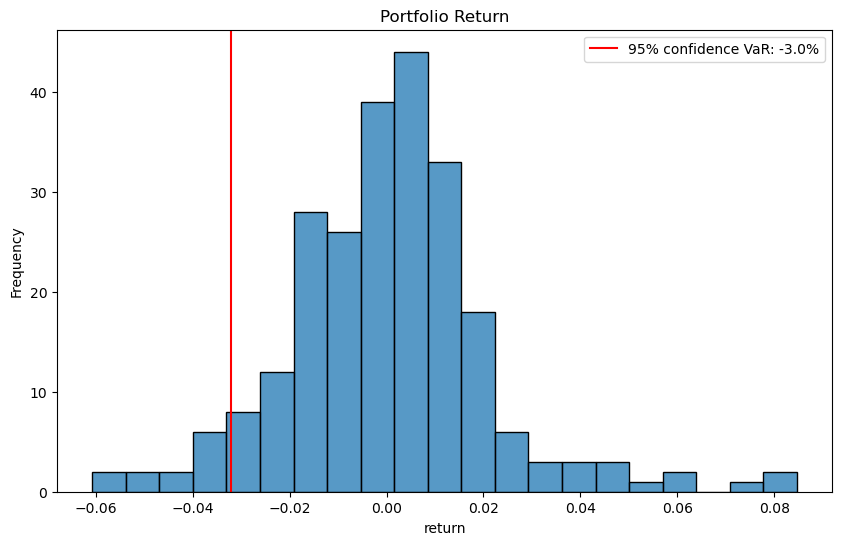

In [162]:
var_start = '2021-01-31'
var_end = '2022-01-31'
var = rp.VaR_Hist(return_df.loc[var_start:var_end]['SUM'], alpha=0.05)
plt.figure(figsize=(10, 6))
sns.histplot(return_df.loc[var_start:var_end]['SUM'])
plt.title('Portfolio Return')
plt.xlabel('return')
plt.ylabel('Frequency')
plt.axvline(x=-var, color='red', linestyle='-', label=f'95% confidence VaR: -{round(var, 2)*100}%')
plt.legend()
plt.show()